# Efficient Gridding in Python

In order to use this approach, you need to have the following Python packages installed:
    - Numpy
    - Scipy
    - Scikit Image
    - Pyproj
    
All of these packages are part of the [Anaconda Python Distribution](https://www.continuum.io/downloads). Anaconda Python Distribution works on Windows, Mac, and Linux Computers and does not require root/admin access.

## Create the Gridder Class

This code needs to either be included at the top of your script or placed into its own file and imported.

In [1]:
import numpy as np
import scipy.spatial as ss
from skimage import draw as skdraw


class Gridder(object):
    def __init__(self, tx, ty):
        self.tree = self.make_tree(tx, ty)

    def make_empty_grid(self, dtype="int"):
        """
        Returns an emptry grid of the size of the gridder.
        
        Arguments
            dtype [number type] -- The data type of the grid. Defaults
                                   to integer.
                                   
        Returns
            empty numpy grid
        """
        return np.zeros(self.tx.shape, dtype=dtype)

    def make_tree(self, tx, ty, dx=np.inf, center=False):
        """
        The method to create the lookup tree.
        
        Arguments
            tx [2-D array] -- The x coordinates of the grid
            ty [2-D array] -- The y coordinates of the grid
            dx [float] -- The delta between grid cells. Defaults to
                          infinity. This is used to provide slight 
                          speedup be limiting the spatial lookup extent.
                          If you are unsure; do not set this.
            center [bool] -- Boolean to determine whether the
                             lon/lat pair represents the center
                             or lower-left corner of the grid cell.
                             If not center, shift lon/lats to center.
                             Default is False.
                             
        Returns
            KDTree object    
        """
        tx = np.array(tx, copy=True, subok=True)
        ty = np.array(ty, copy=True, subok=True)
        if not center:
            x2 = tx.copy()
            y2 = ty.copy()
            x2[:, :-1] = tx[:, :-1] + (tx[:, 1:] - tx[:, :-1]) / 2.
            y2[:-1, :] = ty[:-1, :] + (ty[1:, :] - ty[:-1, :]) / 2.
            x2[:, -1] += (tx[:, -1] - tx[:, -2]) / 2.
            y2[-1, :] += (ty[-1, :] - ty[-2, :]) / 2.
            tx = x2.copy()
            ty = y2.copy()
            del(x2)
            del(y2)
        self.tx = tx; self.ty = ty; self.dx = dx
        self.tpoints = list(zip(tx.ravel(), ty.ravel()))
        return ss.cKDTree(self.tpoints)

    def _kdtree_query(self, x, y, dx):
        """
        Internal method to do spatial lookup.
        """
        try:
            points = np.asarray(list(zip(x, y)))
        except TypeError:
            points = np.asarray(list(zip([x], [y])))
        dists, inds = self.tree.query(points, k=1, distance_upper_bound=dx)
        bad_inds = np.where(inds >= len(self.tpoints))[0]
        inds = np.delete(inds, bad_inds)
        return np.unravel_index(inds, self.tx.shape)
    
    def grid_points(self, xs, ys):
        """
        Method to grid points.
        
        Arguments
            xs [list/array]: The x-coordinates
            yx [list/array]: The y-coordinates
            
        Returns
            A list of indices representing the points in grid space
        """
        xinds, yinds = self._kdtree_query(xs, ys, self.dx)
        points = list(zip(xinds, yinds))
        return points

    def grid_lines(self, sxs, sys, exs, eys):
        """
        Method to grid line segments.
        
        Arguments
            sxs [list/array]: The starting x-coordinates
            sys [list/array]: The starting y-coordinates
            exs [list/array]: The ending x-coordinates
            eys [list/array]: The ending y-coordinates
        
        Returns
            A list of indicides representing the lines in grid space.

        """
        sxinds, syinds = self._kdtree_query(sxs, sys, self.dx)
        exinds, eyinds = self._kdtree_query(exs, eys, self.dx)
        lines = [skdraw.line(sx, sy, ex, ey) for sx, sy, ex, ey in zip(sxinds, syinds, exinds, eyinds)]
        return lines
    
    def grid_polys(self, xs, ys):
        """
        Method to grid/fill polygons. Note: To just grid the boundary,
        use the "grid_lines" method.
        
        Arguments
            xs [list/array]: A list/array of lists/arrays of the x-coordinates 
                             of the polygons to grid.
            ys [list/array]: A list/array of lists/arrays of the y-coordinates 
                             of the polygons to grid.
                             
        Returns
            A list of arrays of indices representing the filled polygons
            in grid space
        """
        xinds = []
        yinds = []
        for x, y in zip(xs, ys):
            _xinds, _yinds = self._kdtree_query(x, y, self.dx)
            xinds.append(_xinds)
            yinds.append(_yinds)
        polys = [skdraw.polygon(_x, _y) for _x, _y in zip(xinds, yinds)]
        return polys
        

## Understanding How the Gridder Works

This gridding class utilizes a KDTree object to perform efficient spatial lookup queries.
This class works by taking the coordinates of a grid as initial inputs.
Then, you can pass coordinates to the class and it will return the indices of the grid that contain the passed coordinates.
So, in order to to use the class, you first need to...


## Determine your Grid

If you already have a grid, great. 
If not we can create one. 
If you are gridding data that are in cartesian coordiantes, feel free to skip this next part.
However, if you are gridding in longitude/latitude space, this next part is **extremely** important to insure the correct gridding results.

### Projecting Your Data onto a Cartesian Grid

If your grid is in longitude/latitude space, you need to convert it to the appropriate cartesian space.
The reason for this is that in longitude/latitude space, the distance between coordinates is not constant; it varies with increasing latitude.
This variance can result in some issues when gridding.
Namely, a neighboring grid point may be chosen rather than the one expected.

To account for this, we need to use map projections to convert from longitude/latitude to cartesian (x/y) space.
Fortunately, Python has a library that can do this for us: ```pyproj```.
Pyproj is a python wrapper to the PROJ4 library. 
I will not cover most of the details in how to create a pyproj projection object, however in a nutshell it can be accomplished by passing in a proj4 string to the pyproj.Proj method.

**Please note: If you have a predefined longitude/latitude grid, such as from a numerical model, you *__must__* use the projection defined to create the longitude/latitude grid (e.g., the projection defined by the model).**

In [2]:
import pyproj

proj4string = '+units=m +lat_0=39.0 +lon_0=-96.0 +lat_1=33 +rsphere=(6378137.0, 298.257222101) +proj=lcc +x_0=0 +lat_2=45 +y_0=0 +datum=NAD83 '
proj = pyproj.Proj(proj4string)

Now that we have a pyproj projection object, we can convert from longitude/latitude coordinates to projection coordinates.
In this particular case, I do not have a predefined grid, so I will create a constant delta-x, delta-y grid in the projection definied above.
Here's how:

In [3]:
lonmin = -122  # lower-left corner longitude
latmin = 23    # lower-left corner latitude
lonmax = -57.5   # upper-right corner longitude
latmax = 52    # upper-right corner latitude

Now we need to convert the coordinates into projection space. 
To do this, we can simply call our projection object defined above.

In [4]:
xmin, ymin = proj(lonmin, latmin)
xmax, ymax = proj(lonmax, latmax)

print("lower-left corner longitude:  %f -> %f" % (lonmin, xmin))
print("lower-left corner latitude:     %f -> %f" % (latmin, ymin))
print("upper-right corner longitude:  %f -> %f" % (lonmax, xmax))
print("upper-right corner latitude:    %f -> %f" % (latmax, ymax))

lower-left corner longitude:  -122.000000 -> -2713800.995982
lower-left corner latitude:     23.000000 -> -1395802.594712
upper-right corner longitude:  -57.500000 -> 2622553.767371
upper-right corner latitude:    52.000000 -> 2013802.241484


Now, taking the projection coordinates, create an equally spaced grid between these points.

In [5]:
dx = dy = 80*1000.  # constant delta-x & delta-y in meters
                    # This results in an 80-km grid.

# Create the x-coordinates/y-coordinates that make up the grid
xaxis = np.arange(xmin, xmax+1, dx)
yaxis = np.arange(ymin, ymax+1, dy)

# The above is merely the x and y-axes. To create the grid we
# need to mesh the above axes.
X, Y = np.meshgrid(xaxis, yaxis)

# Now that we have the grid points in projection space
# we can do the "inverse" of the projection to get back
# the longitude/latitude coordinates.
lons, lats = proj(X, Y, inverse=True)

We can create a scatter plot of our grid to ensure that we are in projection space.
A scatter plot of the grid cells in projection space should look like a rectangle.
A scatter plot of the grid cells in longitude/latitude space should look like a paper fan.

We'll use the matplotlib package to handle our plotting, so I'll import it below.

In [6]:
import matplotlib.pyplot as plt

Here's the projection grid.
Notice how it's a rectangle.

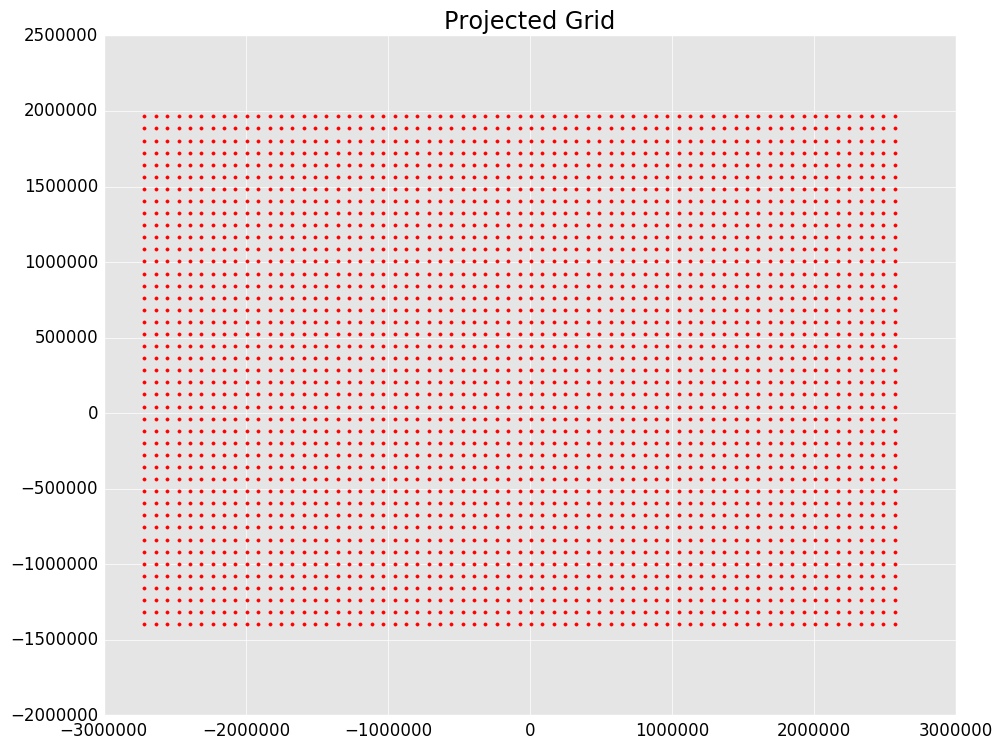

In [7]:
# Plot the Projection Grid
plt.scatter(X, Y, marker=".", color='r')
plt.title("Projected Grid")

Here's the longitude/latitude grid.
Notice how it is fan shaped.

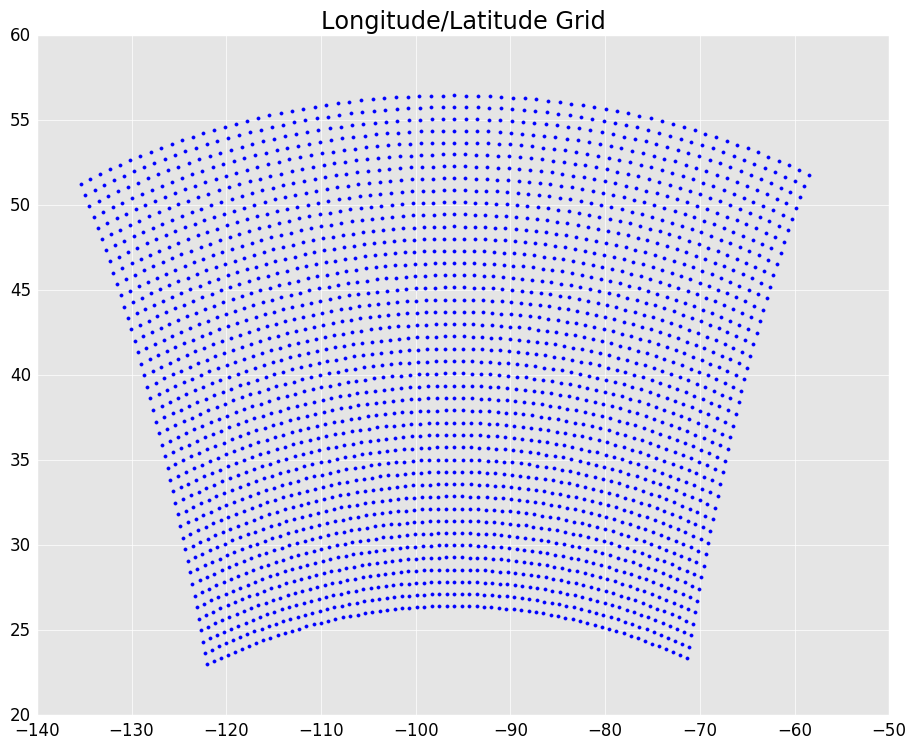

In [8]:
# Plot the Longitude/Latitude Grid
plt.scatter(lons, lats, marker=".", color="b")
plt.title("Longitude/Latitude Grid")

### Convert Your Data to Projection Space

Now that we have a grid in projection space, we need to convert the data that needs to be gridded into projection space as well.
We can do this the same was a we converted the corners of our grid.

In my case, I don't have data, so I'll use numpy to generate random data

In [9]:
rand_x_lonlat = np.random.uniform(-115, -75, 10000) # 10,000 x-coordinates
rand_y_lonlat = np.random.uniform(30, 50, 10000) # 10,000 y-coordinates

Now, let's visualized where these points lie.
Once again, use matplotlib.

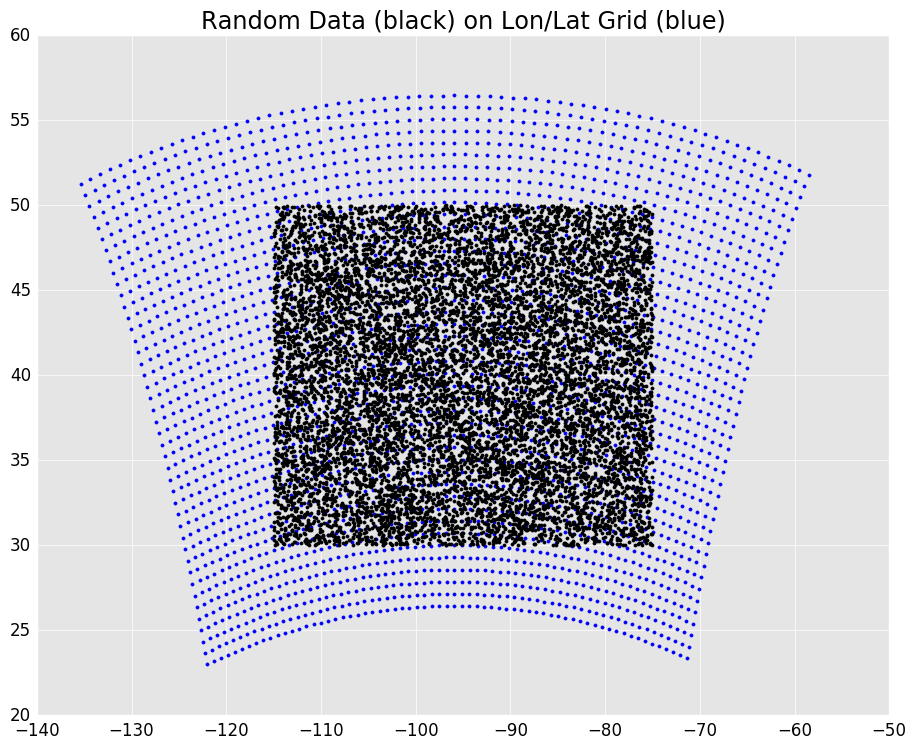

In [10]:
plt.scatter(lons, lats, marker=".", color='b')
plt.scatter(rand_x_lonlat, rand_y_lonlat, marker=".", color='k')
plt.title("Random Data (black) on Lon/Lat Grid (blue)")


Now, let's convert our data from longitude/latitude space to projection space.
Fortunately, our pyproj projection class can handle arrays of data and convert all 10,000 points at once.

In [11]:
rand_x_proj, rand_y_proj = proj(rand_x_lonlat, rand_y_lonlat)

Now let's visualize everything in projection space.

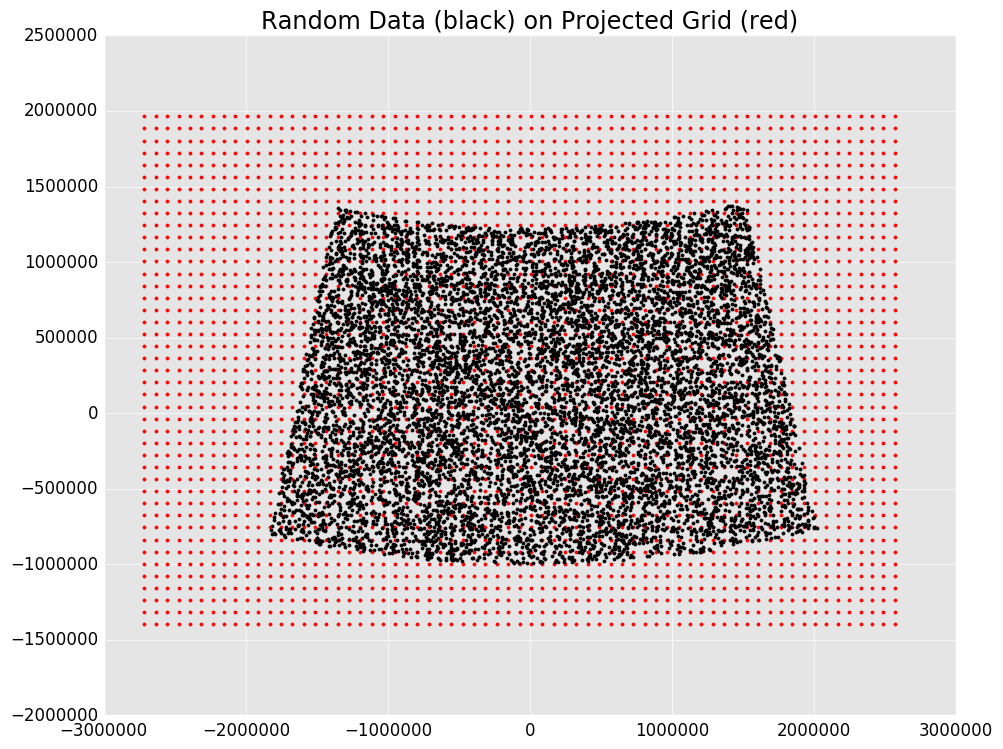

In [12]:
plt.scatter(X, Y, marker=".", color='r')
plt.scatter(rand_x_proj, rand_y_proj, marker=".", color='k')
plt.title("Random Data (black) on Projected Grid (red)")


Now, it's time to grid.

## Using the Gridder -- Griding Point Data

As previously implied, to instantiate our gridder object, we pass it two, two-dimensional arrays: one for the x-grid points and one for the y-grid points.

In [13]:
G = Gridder(X, Y)

Now that we have created our gridding object, let's grid our randomly generate data!

In [14]:
grid = np.zeros(G.tx.shape)  # Create a grid of same size as used to create our gridding object, but set to 0.
points = G.grid_points(rand_x_proj, rand_y_proj)  # Run the Gridder!

# Loop through the returned points and increment
# that grid cell by 1.
for point in points:
    grid[point] += 1

Now, let's view it!

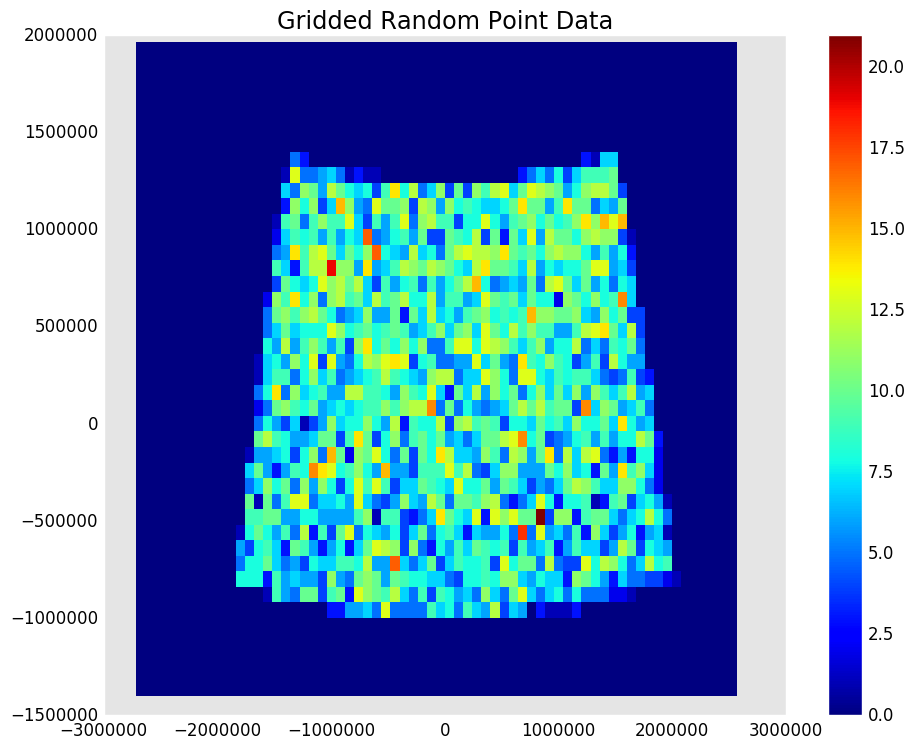

In [15]:
plt.pcolormesh(X, Y, grid)  # Create a raster image
plt.colorbar()        # Add Colorbar
plt.title("Gridded Random Point Data")

## Using the Gridder -- Line/Path Data

To plot paths, we use a similar approach as with points.
The only difference is that in addition to including the starting point, we need to include the ending point.
To illustrate this, let's create a new set of random data, designated to be the ending points of our fictious line data.

In [16]:
rand_x_end_lonlat = np.random.uniform(-115, -75, 10000) # 10,000 x-coordinates
rand_y_end_lonlat = np.random.uniform(30, 50, 10000) # 10,000 y-coordinates
rand_x_end_proj, rand_y_end_proj = proj(rand_x_end_lonlat, rand_y_end_lonlat)

Now let's view the fictitious paths.

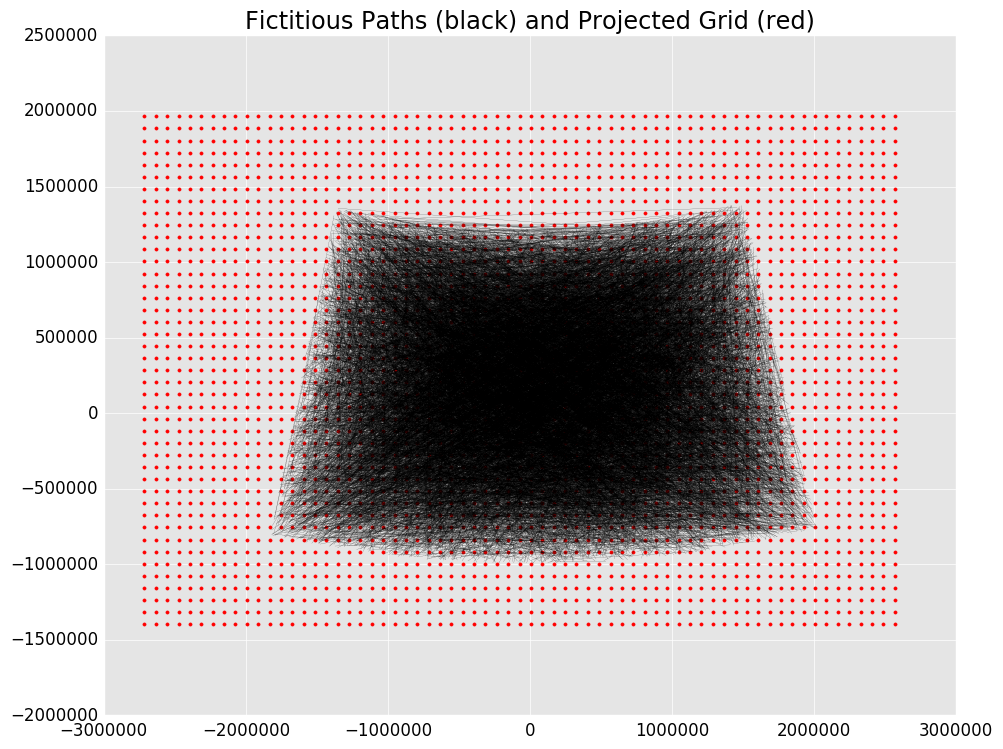

In [17]:
for sx, sy, ex, ey in zip(rand_x_proj, rand_y_proj, rand_x_end_proj, rand_y_end_proj):
    plt.plot([sx, ex], [sy, ey], color="k", lw=0.1)
plt.scatter(X, Y, marker=".", color='r')
plt.title("Fictitious Paths (black) and Projected Grid (red)")

Now let's grid the paths!

In [18]:
# Create a grid of same size as used to create our gridding object, but set to 0.
grid = np.zeros(G.tx.shape)

# Run the Gridder!
paths = G.grid_lines(rand_x_proj, rand_y_proj, rand_x_end_proj, rand_y_end_proj)

# Loop through the returned paths and increment
# the grid cells touched by the path by 1.
for path in paths:
    grid[path] += 1

Now let's view the gridded data

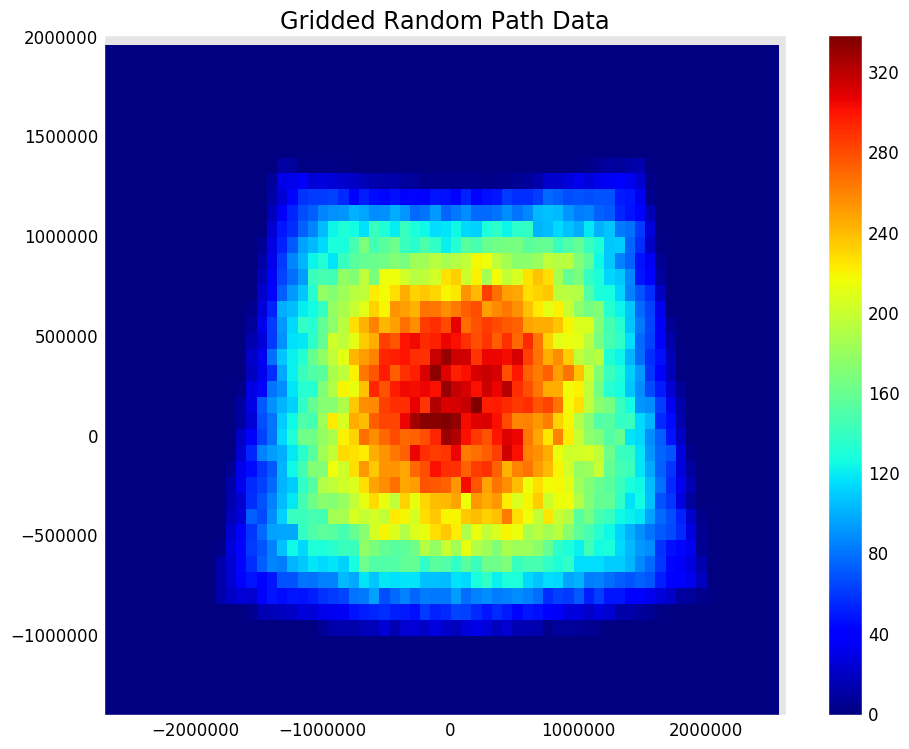

In [19]:
plt.pcolormesh(X, Y, grid)  # Create a raster image
plt.colorbar()        # Add Colorbar
plt.xlim(xmin, xmax)  # Clip the x-bounds of the plot to the x-values of the grid
plt.ylim(ymin, ymax)  # Clip the y-bounds of the plot to the y-values of the grid
plt.title("Gridded Random Path Data")